In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
import torch
import torch_geometric
import torch
import os
import os.path as osp
import numpy as np
from tqdm import tqdm as tqdm
torch.manual_seed(1)
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# import electron datasets
import glob
raw_dir="/grid_mnt/data__data.polcms/cms/sghosh/hackathon/graphsv2_thr0p2phi0p2/"
#raw_dir='/data_CMS/cms/sghosh/elecgraphs/V1condor/'
fnamelist = [filepath for filepath in glob.glob(raw_dir+'data*.pt')]
data_list_ele = []
etav = []
for i in tqdm(fnamelist):
    idx = torch.load(i)
    #print(idx.x.shape[0])
    if idx.x.shape[0] < 3:
        continue
    if not(np.any(idx.nodelabel.numpy())):  ### remove where there are no eles matched
        continue
    idx.edge_index = idx.edgeidx.long()
    idx.edgeidx = []
    data_list_ele.append(idx)
    #data_list.append(torch.load(i))
    

#data_list=[x for x in data_list if (x.y<100.)]   
print((data_list_ele[0].x))
#print(data_list_pho[0].z)
print(len(data_list_ele))
totalevele = len(data_list_ele)
#trainev =

100%|██████████| 58917/58917 [00:18<00:00, 3115.89it/s]

tensor([[ 6.1590e+01, -5.8120e+00,  3.2511e+02,  2.0705e+00,  3.5077e-01,
          1.8955e-03,  9.3646e-01,  1.7226e-01],
        [ 5.4722e+01, -9.9162e+00,  3.2988e+02,  7.7504e+00,  8.3204e-02,
         -7.8913e-02,  9.9340e-01,  9.4590e-02],
        [ 5.4792e+01, -1.5136e+01,  3.3019e+02,  1.5054e+01,  1.3933e-01,
         -5.3625e-02,  9.8879e-01,  2.5845e-02],
        [ 5.7434e+01, -1.7210e+01,  3.2712e+02,  3.0184e+00, -4.5120e-02,
         -2.9879e-01,  9.5325e-01,  3.3228e-01],
        [ 5.8495e+01, -1.4197e+01,  3.2995e+02,  7.7778e-01,  1.5388e-01,
         -4.1134e-02,  9.8723e-01,  2.0848e-02],
        [ 6.0202e+01, -1.1856e+01,  3.3360e+02,  5.2617e+00,  1.8776e-01,
         -1.2751e-01,  9.7390e-01,  9.3655e-02],
        [ 6.1393e+01, -7.7536e+00,  3.3109e+02,  3.0767e+00,  2.7094e-01,
          6.8845e-02,  9.6013e-01,  1.2980e-01],
        [ 5.3352e+01, -1.9245e+01,  3.3362e+02,  2.4999e+00,  1.4660e-01,
         -9.3981e-02,  9.8472e-01,  3.8743e-02],
        [ 5.8178

In [16]:
#del data_list_comb
totalevele = len(data_list_ele)
ntrain = int(0.8*totalevele)
import random


random.shuffle(data_list_ele)
import torch_geometric
ntrainbatch = 100
ntestbatch = 100
trainloader = torch_geometric.data.DataLoader(data_list_ele[:ntrain], batch_size=ntrainbatch)
testloader = torch_geometric.data.DataLoader(data_list_ele[ntrain:], batch_size=ntestbatch)
#batch_size = ntrainbatch
epoch_size = len(data_list_ele[:ntrain])
print("epoch size,batch_size:",epoch_size,ntrainbatch)

epoch size,batch_size: 16736 100


In [5]:
import os
import os.path as osp
import math

import numpy as np
import torch
import gc
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch.utils.checkpoint import checkpoint
from torch_cluster import knn_graph

from torch_geometric.nn import EdgeConv, NNConv
#from torch_geometric.nn.pool.edge_pool import EdgePooling

from torch_geometric.utils import normalized_cut
from torch_geometric.utils import remove_self_loops
from torch_geometric.utils.undirected import to_undirected
from torch_geometric.nn import (graclus, max_pool, max_pool_x,
                                global_mean_pool, global_max_pool,
                                global_add_pool,BatchNorm)

transform = T.Cartesian(cat=False)

def normalized_cut_2d(edge_index, pos):
    row, col = edge_index
    edge_attr = torch.norm(pos[row] - pos[col], p=2, dim=1)
    return normalized_cut(edge_index, edge_attr, num_nodes=pos.size(0))

class NodeNetwork(nn.Module):
    # Nodeclassification network 
    
    def __init__(self, input_dim=5, hidden_dim=64, output_dim=1, k=16, aggr='add',
                 norm=torch.tensor([1./500., 1./500., 1./54., 1/25., 1./1000.])):
 #                norm=torch.tensor([1., 1., 1., 1., 1.])):
        super(NodeNetwork, self).__init__()

        self.datanorm = nn.Parameter(norm,requires_grad=False)
        
        self.k = k
        start_width = 2 * hidden_dim
        middle_width = 3 * hidden_dim // 2

        
        
        self.inputnet =  nn.Sequential(
            nn.Linear(input_dim, hidden_dim*2),            
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim*2, hidden_dim*2),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim*2, hidden_dim*2),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim*2, hidden_dim*2),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ELU(),
        )
        
        
        convnn1 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.ELU(),
                                nn.Dropout(0.2),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.ELU()
                                )
        convnn2 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.ELU(),
                                nn.Dropout(0.2),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.ELU()
                                )
        
        convnn3 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.ELU(),
                                nn.Dropout(0.2),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.ELU(),
                                nn.Linear(hidden_dim, output_dim)                                           
                                )
                
        self.edgeconv1 = EdgeConv(nn=convnn1, aggr=aggr)
        self.edgeconv2 = EdgeConv(nn=convnn2, aggr=aggr)
        self.edgeconv3 = EdgeConv(nn=convnn3, aggr=aggr)
        
        self.output = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                    nn.ELU(),
                                    nn.Dropout(0.2),
                                    #nn.Softplus(),
                                    nn.Linear(hidden_dim, hidden_dim//2),
                                    nn.ELU(),
                                    nn.Dropout(0.2),
                                    #nn.Softplus(),
#                                    nn.Linear(hidden_dim//2, hidden_dim//2),#added
 #                                   nn.ELU(),
                                    #nn.Softplus(),
                                    nn.Linear(hidden_dim//2, output_dim)
                                   )
        self.batchnorm1 = BatchNorm(hidden_dim)
        
    def forward(self, data):        
        data.x = self.datanorm * data.x
        data.x = self.inputnet(data.x)
        
        #data.edge_index = to_undirected(knn_graph(data.x, self.k, data.batch, loop=False, flow=self.edgeconv1.flow))
        data.x = self.edgeconv1(data.x, data.edge_index)
        data.x = self.edgeconv2(data.x, data.edge_index)
        data.x = self.edgeconv3(data.x, data.edge_index)
        
        src, dst = data.edge_index
        score = (data.x[src] * data.x[dst]).sum(dim=-1)
        return score

In [20]:
from lr_regulation import *

from tqdm import tqdm_notebook as tqdm


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.drn = NodeNetwork(input_dim=8,
                                           hidden_dim=100, #50
                                           k=6,#16
                                           output_dim=10,
                                           norm=torch.tensor([1., 1., 1., 1.,1.,1.,1.,1.]))
        
    def forward(self, data):
        logits = self.drn(data)
        #return F.softplus(logits)
        return torch.sigmoid(logits)
        #return logits
device = torch.device('cuda:3')#('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
model = Net().to(device)
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
#optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-3)
scheduler = CyclicLRWithRestarts(optimizer, ntrainbatch, epoch_size, restart_period=200, t_mult=1.2, policy="cosine")

from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum() 

focalloss = FocalLoss()        


     
#losscat = torch.nn.CrossEntropyLoss(weight=torch.tensor([1., 2.],device="cuda:1"))    
losscat = torch.nn.CrossEntropyLoss()#weight=torch.tensor([1., 2.],device="cuda:1"))    
def categorical_loss(outputa,trutha,alpha):
    total_loss =  losscat(outputa[:,:2],trutha[:,0].long()) + alpha*resoloss(outputa[:,2],trutha[:,1])
    return total_loss


def categorical_loss_only(outputa,trutha):
    total_loss =  losscat(outputa,trutha) 
    return total_loss


def bcategorical_loss(outputa,trutha):
    total_loss = F.binary_cross_entropy(outputa, trutha.float())
    return torch.mean(total_loss)

#model.train()
def train(epoch):
    model.train()
    #torch.cuda.empty_cache()
    scheduler.step()
    loss = []
    for data in tqdm(trainloader):
            data = data.to(device)        
            optimizer.zero_grad()
            #print(data.x.size())
            result = model(data)
            #print(result.shape,data.edgelabel.shape)
            #lossc = focalloss(result, data.edgelabel.type(torch.int64))
            #lossc = categorical_loss_only(result, data.edgelabel.type(torch.int64))
            lossc = bcategorical_loss(result, data.edgelabel.type(torch.int64))
            loss.append(lossc.item()) 
            lossc.backward()
            optimizer.step()
            scheduler.batch_step()
    print( 'batches for train:',len(loss)) 
#    print('loss',loss)
    print('train loss:',np.mean(np.array(loss)))
    return np.mean(np.array(loss))




def gaussian(x,  mean,a, sigma):
    return a * np.exp(-((x - mean)**2 / (2 * sigma**2)))

def evaluate(epoch):
        """"Evaluate the model"""
        model.zero_grad()
        #torch.cuda.empty_cache()
        model.eval()
        pred = []
        true = []
        loss= []
        
        correct = 0
        predc = []
        truec = []
        for data in tqdm(testloader):
            data = data.to(device)        
            result = model(data)
            #lossc = resoloss(result, data.y)
            #lossc = categorical_loss_only(result, data.label)
            #lossc = focalloss(result, data.edgelabel.type(torch.int64))
            #lossc = categorical_loss_only(result, data.edgelabel.type(torch.int64))
            lossc = bcategorical_loss(result, data.edgelabel.type(torch.int64))
#            print (result.item(),data.y.item())
#            frac.append((result.item() - data.y.item())/data.y.item())
            loss.append(lossc.item())

            for i in result:
                #pred.append(i.detach().cpu()[2])
                predc.append(i.detach().cpu())
                #print(i.detach().cpu().argmax())
            for i in data.edgelabel.detach():
                #true.append(i.detach().cpu()[1])
                truec.append(i.detach().cpu().flatten())
                #print(i.detach().cpu())
            
        #print(predc,truec)
        predc = np.array(predc)
        predc[predc < 0.5] = 0.
        predc[predc > 0.5] = 1.
        truec = np.array(truec)
        
        #eleacc = [] 
        #puacc = []
        
        totacc = np.equal(predc,truec).sum()/len(truec)
        eleacc = np.equal(predc[truec==1],truec[truec==1]).sum()/len(truec[truec==1])
        puacc = np.equal(predc[truec==0],truec[truec==0]).sum()/len(truec[truec==0])


        return np.mean(np.array(loss)), totacc, eleacc, puacc
        


  2%|▏         | 3/168 [00:00<00:05, 29.25it/s]

epoch: 1


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 56.03413359324137


  4%|▎         | 6/168 [00:00<00:02, 55.41it/s]

test total acc, ele acc, pu acc: 0.36579514809933217 0.7936458005662158 0.3581604472585208
new best test loss: 63.34293910435268
epoch: 2


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 63.6883088520595


  4%|▎         | 6/168 [00:00<00:02, 57.63it/s]

test total acc, ele acc, pu acc: 0.4019775989764574 0.7514941805599245 0.3957407157932552
new best test loss: 59.70481854393368
epoch: 3


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 63.87094570341564


  4%|▎         | 6/168 [00:00<00:02, 57.39it/s]

test total acc, ele acc, pu acc: 0.01754250514252941 1.0 1.1226368494319457e-05
epoch: 4


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 68.05055570602417


  2%|▏         | 3/168 [00:00<00:05, 27.70it/s]

test total acc, ele acc, pu acc: 0.0185847979661503 0.9993708713431897 0.0010833445597018276
epoch: 5


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 74.44116758164905


  3%|▎         | 5/168 [00:00<00:03, 48.24it/s]

test total acc, ele acc, pu acc: 0.017553534696218516 1.0 2.2452736988638914e-05
epoch: 6


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 93.00690446581159


  3%|▎         | 5/168 [00:00<00:03, 47.85it/s]

test total acc, ele acc, pu acc: 0.017553534696218516 1.0 2.2452736988638914e-05
epoch: 7


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 93.03328382401239


  4%|▎         | 6/168 [00:00<00:03, 53.37it/s]

test total acc, ele acc, pu acc: 0.017553534696218516 1.0 2.2452736988638914e-05
epoch: 8


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 93.00118482680548


  4%|▎         | 6/168 [00:00<00:02, 55.63it/s]

test total acc, ele acc, pu acc: 0.017553534696218516 1.0 2.2452736988638914e-05
epoch: 9


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 93.04658748990013


  4%|▎         | 6/168 [00:00<00:02, 54.12it/s]

test total acc, ele acc, pu acc: 0.017553534696218516 1.0 2.2452736988638914e-05
epoch: 10


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 93.01157624380929


100%|██████████| 42/42 [00:13<00:00,  3.05it/s]


test total acc, ele acc, pu acc: 0.017553534696218516 1.0 2.2452736988638914e-05


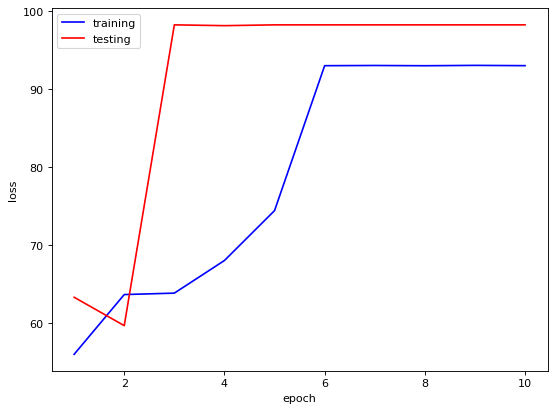

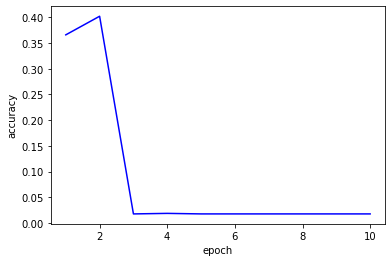

No handles with labels found to put in legend.


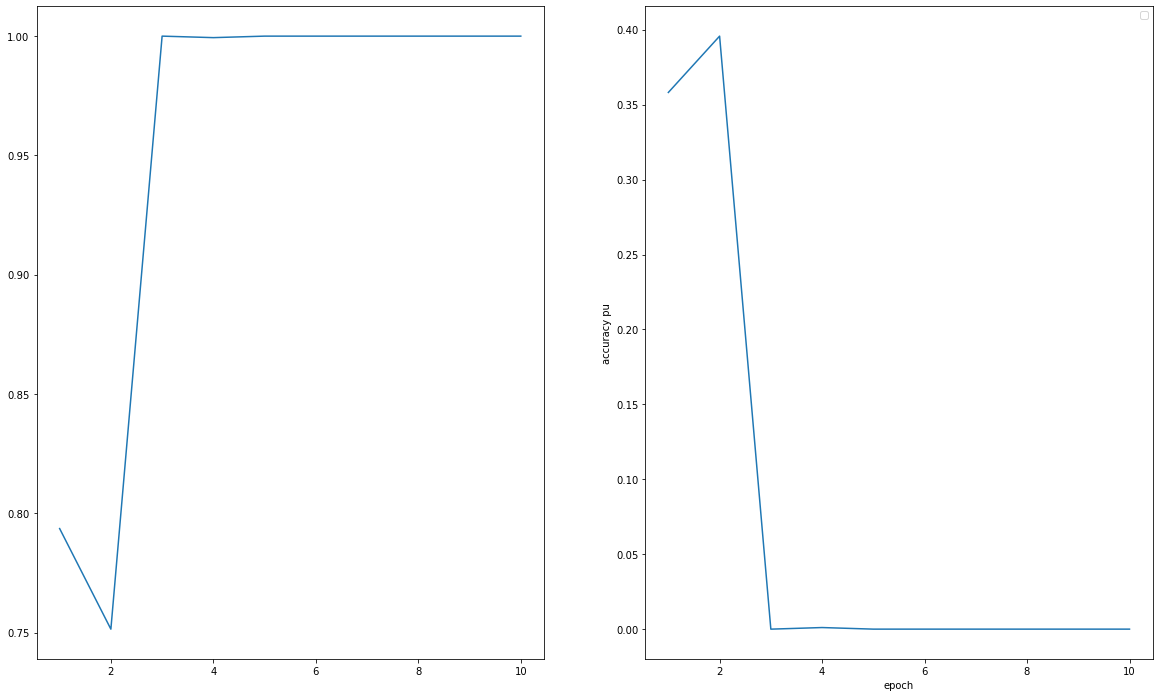

  4%|▎         | 6/168 [00:00<00:02, 58.59it/s]

epoch: 11


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 93.05547473544166


  2%|▏         | 3/168 [00:00<00:06, 26.98it/s]

test total acc, ele acc, pu acc: 0.017553534696218516 1.0 2.2452736988638914e-05
epoch: 12


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 93.00788643246605


  2%|▏         | 3/168 [00:00<00:06, 27.43it/s]

test total acc, ele acc, pu acc: 0.017553534696218516 1.0 2.2452736988638914e-05
epoch: 13


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 93.04786246163505


  3%|▎         | 5/168 [00:00<00:03, 47.99it/s]

test total acc, ele acc, pu acc: 0.017553534696218516 1.0 2.2452736988638914e-05
epoch: 14


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 93.10087698981876


  2%|▏         | 3/168 [00:00<00:06, 27.18it/s]

test total acc, ele acc, pu acc: 0.017553534696218516 1.0 2.2452736988638914e-05
epoch: 15


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 93.01939632779076


  2%|▏         | 3/168 [00:00<00:05, 28.51it/s]

test total acc, ele acc, pu acc: 0.017553534696218516 1.0 2.2452736988638914e-05
epoch: 16


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 68.54483647573562


  2%|▏         | 3/168 [00:00<00:05, 28.73it/s]

test total acc, ele acc, pu acc: 0.27379212600162134 0.8977665932683234 0.2626577304773452
epoch: 17


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.944089503515336


  4%|▎         | 6/168 [00:00<00:02, 59.75it/s]

test total acc, ele acc, pu acc: 0.27379212600162134 0.8977665932683234 0.2626577304773452
epoch: 18


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.91560213906424


  3%|▎         | 5/168 [00:00<00:03, 47.53it/s]

test total acc, ele acc, pu acc: 0.27379212600162134 0.8977665932683234 0.2626577304773452
epoch: 19


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.90214050383795


  2%|▏         | 3/168 [00:00<00:06, 27.11it/s]

test total acc, ele acc, pu acc: 0.27379212600162134 0.8977665932683234 0.2626577304773452
epoch: 20


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.88765591666812


100%|██████████| 42/42 [00:14<00:00,  2.90it/s]


test total acc, ele acc, pu acc: 0.27378109644793225 0.8977665932683234 0.2626465041088509


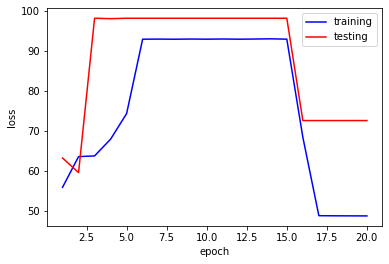

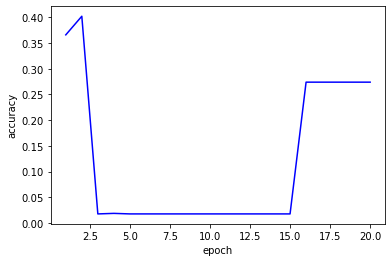

No handles with labels found to put in legend.


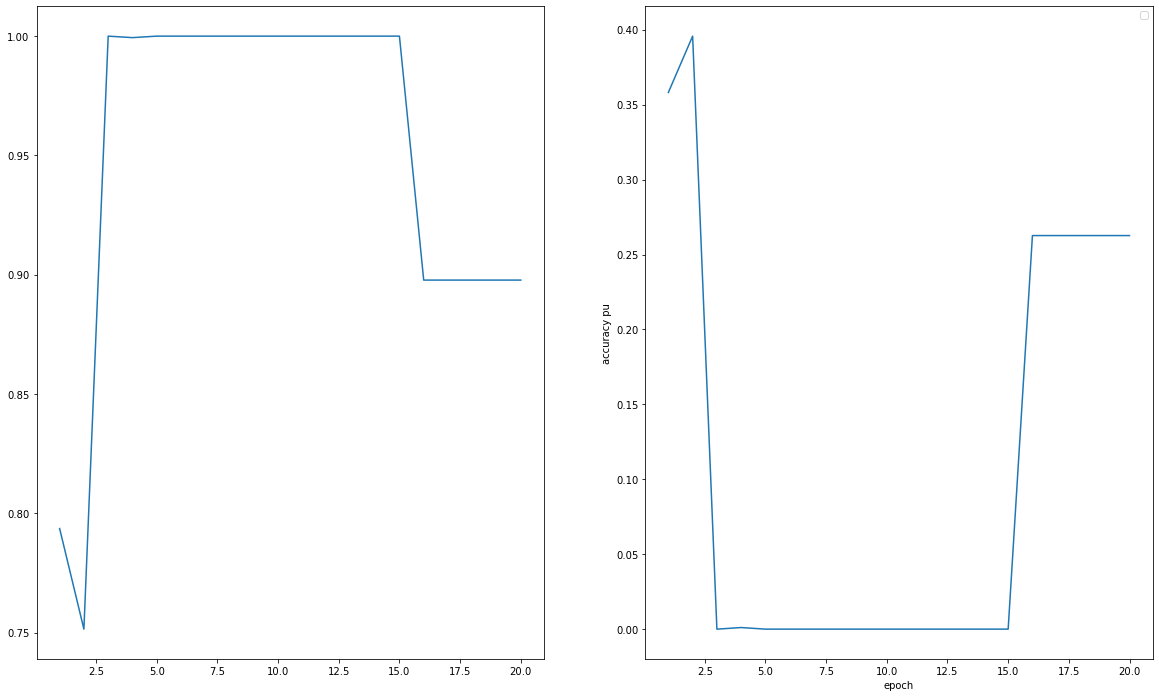

  3%|▎         | 5/168 [00:00<00:03, 48.09it/s]

epoch: 21


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 49.03272279103597


  2%|▏         | 3/168 [00:00<00:05, 27.69it/s]

test total acc, ele acc, pu acc: 0.2737755816710877 0.8977665932683234 0.2626408909246037
epoch: 22


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.96399091538929


  2%|▏         | 3/168 [00:00<00:05, 28.29it/s]

test total acc, ele acc, pu acc: 0.2737645521173986 0.8977665932683234 0.26262966455610937
epoch: 23


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.93360458101545


  4%|▎         | 6/168 [00:00<00:02, 55.27it/s]

test total acc, ele acc, pu acc: 0.2737645521173986 0.8977665932683234 0.26262966455610937
epoch: 24


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.86354316983904


  4%|▎         | 6/168 [00:00<00:02, 58.37it/s]

test total acc, ele acc, pu acc: 0.2737645521173986 0.8977665932683234 0.26262966455610937
epoch: 25


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 49.015174457005095


  3%|▎         | 5/168 [00:00<00:03, 48.79it/s]

test total acc, ele acc, pu acc: 0.2737645521173986 0.8977665932683234 0.26262966455610937
epoch: 26


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.99771981012253


  3%|▎         | 5/168 [00:00<00:03, 48.49it/s]

test total acc, ele acc, pu acc: 0.273759037340554 0.8977665932683234 0.26262405137186223
epoch: 27


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.91875507718041


  2%|▏         | 3/168 [00:00<00:06, 27.24it/s]

test total acc, ele acc, pu acc: 0.273759037340554 0.8977665932683234 0.26262405137186223
epoch: 28


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.97054690406436


  2%|▏         | 3/168 [00:00<00:05, 28.57it/s]

test total acc, ele acc, pu acc: 0.2737645521173986 0.8977665932683234 0.26262966455610937
epoch: 29


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.96180779593332


  4%|▎         | 6/168 [00:00<00:02, 55.10it/s]

test total acc, ele acc, pu acc: 0.2737645521173986 0.8977665932683234 0.26262966455610937
epoch: 30


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.927074568612234


100%|██████████| 42/42 [00:13<00:00,  3.05it/s]


test total acc, ele acc, pu acc: 0.2737645521173986 0.8977665932683234 0.26262966455610937


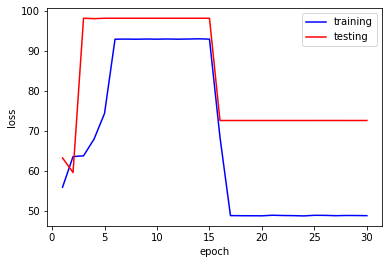

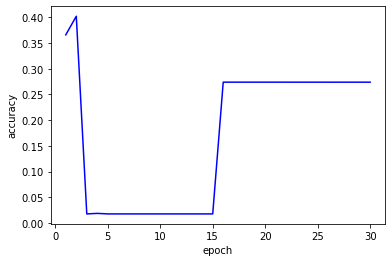

No handles with labels found to put in legend.


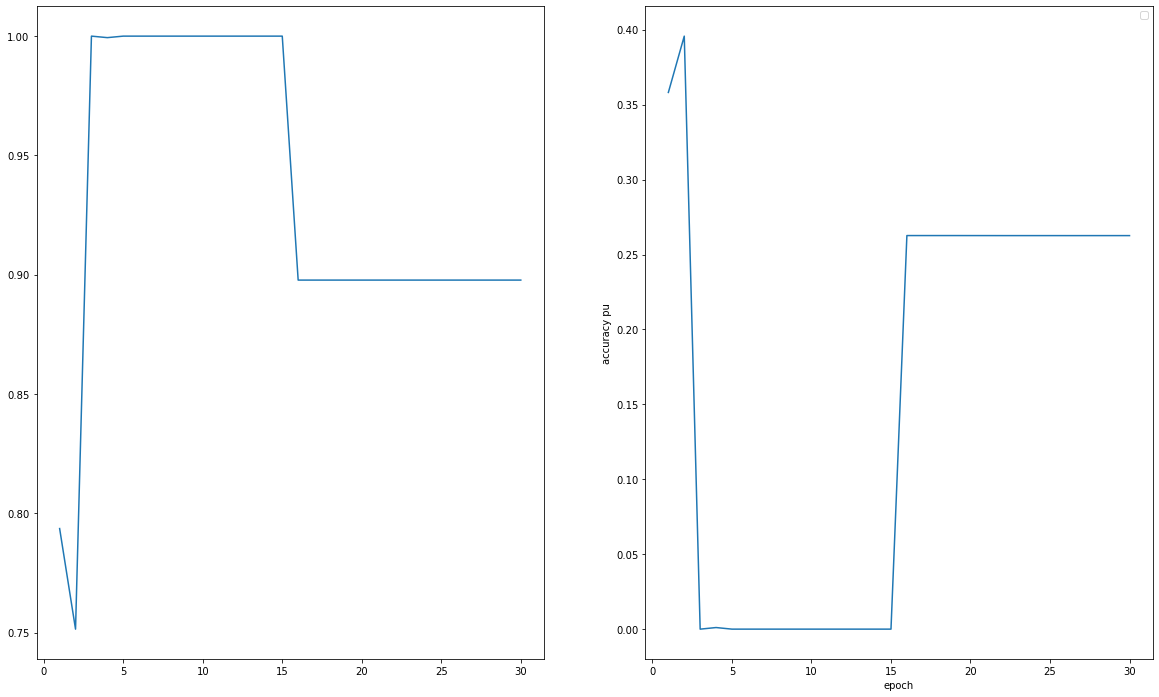

  4%|▎         | 6/168 [00:00<00:02, 54.33it/s]

epoch: 31


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.90988104684012


  4%|▍         | 7/168 [00:00<00:02, 60.95it/s]

test total acc, ele acc, pu acc: 0.2737645521173986 0.8977665932683234 0.26262966455610937
epoch: 32


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.901953402019686


  3%|▎         | 5/168 [00:00<00:03, 47.69it/s]

test total acc, ele acc, pu acc: 0.273759037340554 0.8977665932683234 0.26262405137186223
epoch: 33


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.999355066390265


  2%|▏         | 3/168 [00:00<00:06, 26.97it/s]

test total acc, ele acc, pu acc: 0.27375352256370944 0.8977665932683234 0.26261843818761504
epoch: 34


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.91860603150867


  2%|▏         | 3/168 [00:00<00:05, 27.57it/s]

test total acc, ele acc, pu acc: 0.27374249301002035 0.8977665932683234 0.2626072118191208
epoch: 35


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.99280059905279


  0%|          | 0/168 [00:00<?, ?it/s]

test total acc, ele acc, pu acc: 0.27374249301002035 0.8977665932683234 0.2626072118191208
epoch: 36


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.90936651683989


  4%|▎         | 6/168 [00:00<00:02, 54.79it/s]

test total acc, ele acc, pu acc: 0.2737369782331758 0.8977665932683234 0.2626015986348736
epoch: 37


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.953397296723864


  4%|▎         | 6/168 [00:00<00:02, 54.05it/s]

test total acc, ele acc, pu acc: 0.2737369782331758 0.8977665932683234 0.2626015986348736
epoch: 38


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.86300763629732


  4%|▎         | 6/168 [00:00<00:02, 59.78it/s]

test total acc, ele acc, pu acc: 0.27373146345633126 0.8977665932683234 0.26259598545062646
epoch: 39


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.94775338399978


  3%|▎         | 5/168 [00:00<00:03, 48.45it/s]

test total acc, ele acc, pu acc: 0.27373146345633126 0.8977665932683234 0.26259598545062646
epoch: 40


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.93968477703276


100%|██████████| 42/42 [00:15<00:00,  2.76it/s]


test total acc, ele acc, pu acc: 0.27373146345633126 0.8977665932683234 0.26259598545062646


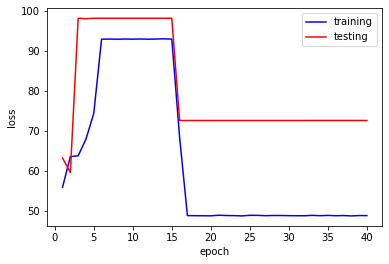

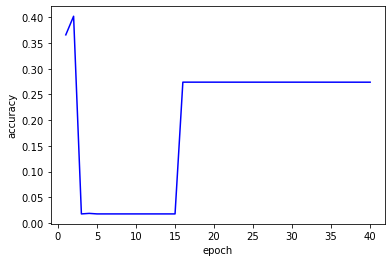

No handles with labels found to put in legend.


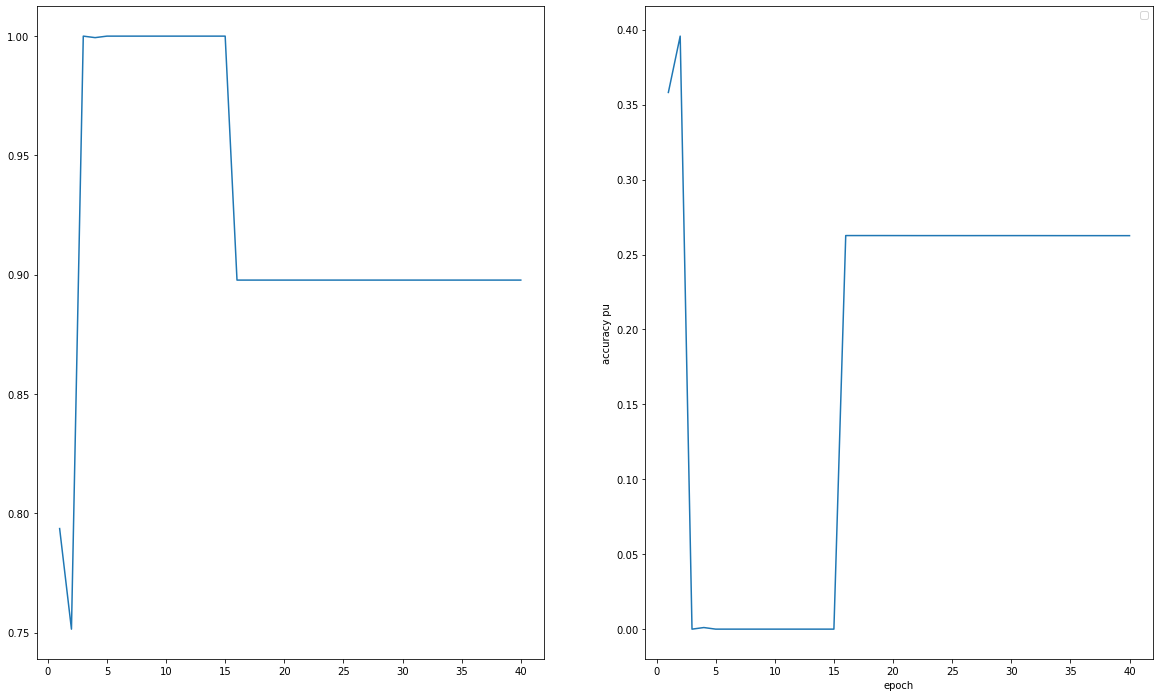

  3%|▎         | 5/168 [00:00<00:03, 46.08it/s]

epoch: 41


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.922057106381374


  3%|▎         | 5/168 [00:00<00:03, 42.68it/s]

test total acc, ele acc, pu acc: 0.27373146345633126 0.8977665932683234 0.26259598545062646
epoch: 42


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.936555680774504


  3%|▎         | 5/168 [00:00<00:03, 46.47it/s]

test total acc, ele acc, pu acc: 0.2737369782331758 0.8977665932683234 0.2626015986348736
epoch: 43


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.96949618203299


  4%|▎         | 6/168 [00:00<00:02, 56.19it/s]

test total acc, ele acc, pu acc: 0.27373146345633126 0.8977665932683234 0.26259598545062646
epoch: 44


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.93745233899071


  4%|▎         | 6/168 [00:00<00:02, 54.75it/s]

test total acc, ele acc, pu acc: 0.27373146345633126 0.8977665932683234 0.26259598545062646
epoch: 45


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.84054978688558


  3%|▎         | 5/168 [00:00<00:03, 48.96it/s]

test total acc, ele acc, pu acc: 0.27373146345633126 0.8977665932683234 0.26259598545062646
epoch: 46


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.974363803863525


  3%|▎         | 5/168 [00:00<00:03, 48.28it/s]

test total acc, ele acc, pu acc: 0.27374249301002035 0.8977665932683234 0.2626072118191208
epoch: 47


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.87916728428432


  3%|▎         | 5/168 [00:00<00:03, 48.95it/s]

test total acc, ele acc, pu acc: 0.27374249301002035 0.8977665932683234 0.2626072118191208
epoch: 48


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.93003297987438


  3%|▎         | 5/168 [00:00<00:03, 49.13it/s]

test total acc, ele acc, pu acc: 0.27373146345633126 0.8977665932683234 0.26259598545062646
epoch: 49


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.9225629397801


  3%|▎         | 5/168 [00:00<00:03, 48.85it/s]

test total acc, ele acc, pu acc: 0.27373146345633126 0.8977665932683234 0.26259598545062646
epoch: 50


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.899003119695756


100%|██████████| 42/42 [00:13<00:00,  3.02it/s]


test total acc, ele acc, pu acc: 0.27373146345633126 0.8977665932683234 0.26259598545062646


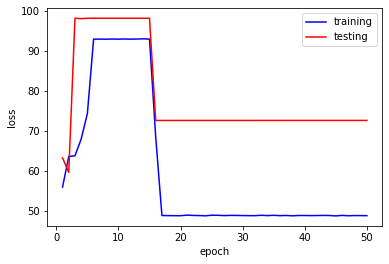

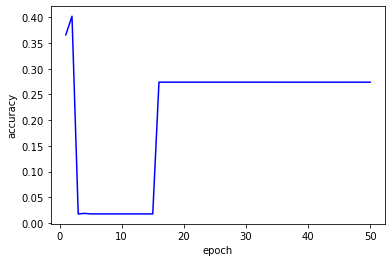

No handles with labels found to put in legend.


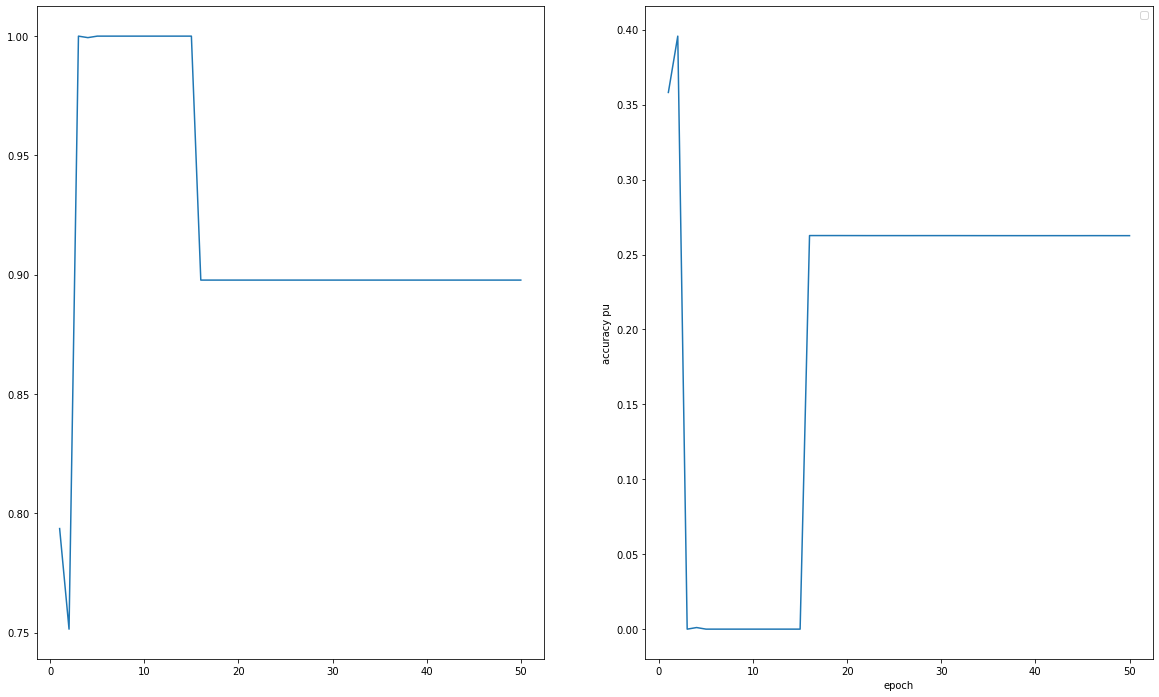

  4%|▎         | 6/168 [00:00<00:02, 55.43it/s]

epoch: 51


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.885424273354666


  4%|▎         | 6/168 [00:00<00:02, 55.53it/s]

test total acc, ele acc, pu acc: 0.27373146345633126 0.8977665932683234 0.26259598545062646
epoch: 52


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.969758215404696


  2%|▏         | 4/168 [00:00<00:04, 34.59it/s]

test total acc, ele acc, pu acc: 0.2737259486794867 0.8977665932683234 0.26259037226637927
epoch: 53


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 49.02988747188023


  2%|▏         | 3/168 [00:00<00:06, 27.28it/s]

test total acc, ele acc, pu acc: 0.2737259486794867 0.8977665932683234 0.26259037226637927
epoch: 54


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.98891458057222


  3%|▎         | 5/168 [00:00<00:03, 48.45it/s]

test total acc, ele acc, pu acc: 0.2737259486794867 0.8977665932683234 0.26259037226637927
epoch: 55


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.97752575647263


  3%|▎         | 5/168 [00:00<00:03, 48.29it/s]

test total acc, ele acc, pu acc: 0.2737259486794867 0.8977665932683234 0.26259037226637927
epoch: 56


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.91547273454212


  3%|▎         | 5/168 [00:00<00:03, 48.83it/s]

test total acc, ele acc, pu acc: 0.2737259486794867 0.8977665932683234 0.26259037226637927
epoch: 57


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.88594665981474


  2%|▏         | 3/168 [00:00<00:06, 27.26it/s]

test total acc, ele acc, pu acc: 0.2737259486794867 0.8977665932683234 0.26259037226637927
epoch: 58


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 49.00626178014846


  4%|▎         | 6/168 [00:00<00:02, 54.10it/s]

test total acc, ele acc, pu acc: 0.2737259486794867 0.8977665932683234 0.26259037226637927
epoch: 59


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 49.00103228432791


  3%|▎         | 5/168 [00:00<00:03, 48.94it/s]

test total acc, ele acc, pu acc: 0.2737259486794867 0.8977665932683234 0.26259037226637927
epoch: 60


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.961366585322786


100%|██████████| 42/42 [00:14<00:00,  2.87it/s]


test total acc, ele acc, pu acc: 0.2737149191257976 0.8977665932683234 0.26257914589788495


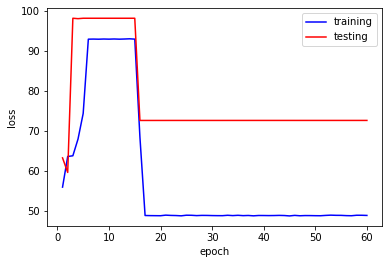

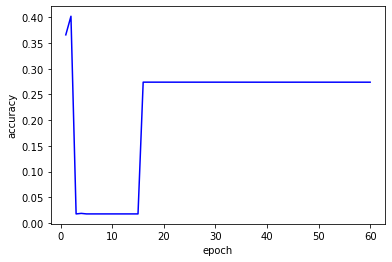

No handles with labels found to put in legend.


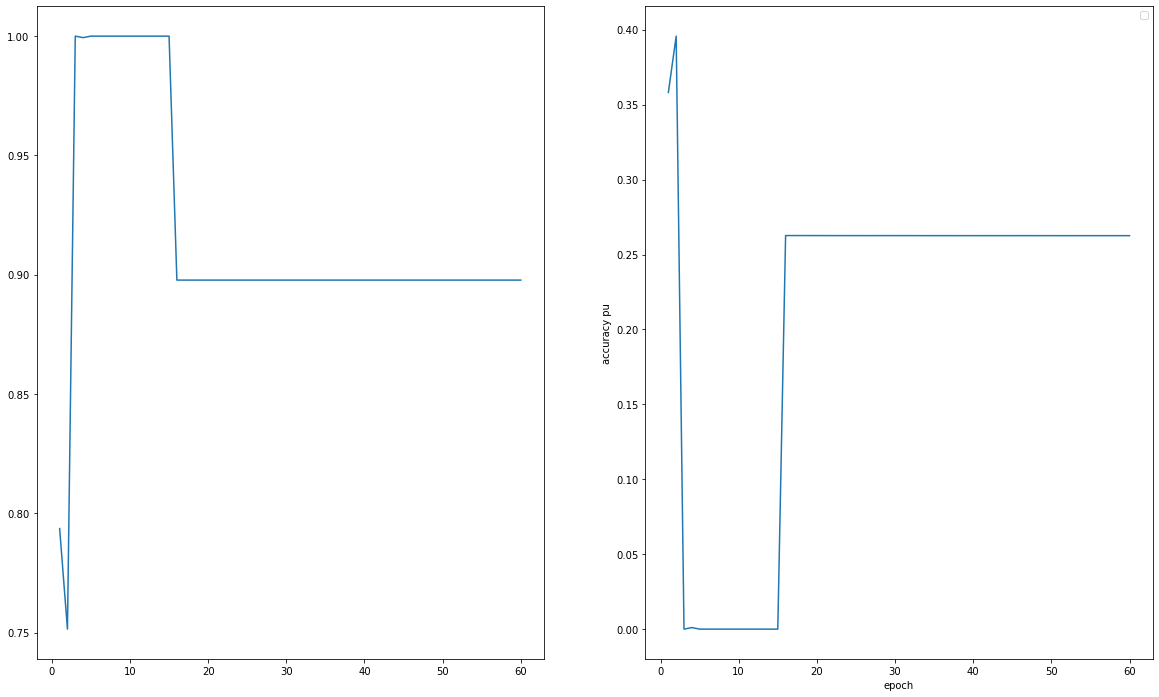

  3%|▎         | 5/168 [00:00<00:03, 47.02it/s]

epoch: 61


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.914836770012265


  2%|▏         | 3/168 [00:00<00:06, 26.89it/s]

test total acc, ele acc, pu acc: 0.273709404348953 0.8977665932683234 0.2625735327136378
epoch: 62


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.91675899142311


  2%|▏         | 3/168 [00:00<00:05, 29.00it/s]

test total acc, ele acc, pu acc: 0.273709404348953 0.8977665932683234 0.2625735327136378
epoch: 63


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.948563734690346


  2%|▏         | 3/168 [00:00<00:06, 26.77it/s]

test total acc, ele acc, pu acc: 0.273709404348953 0.8977665932683234 0.2625735327136378
epoch: 64


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.925589447929745


  4%|▎         | 6/168 [00:00<00:02, 54.36it/s]

test total acc, ele acc, pu acc: 0.27370388957210845 0.8977665932683234 0.2625679195293906
epoch: 65


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.9226963860648


  2%|▏         | 3/168 [00:00<00:05, 27.65it/s]

test total acc, ele acc, pu acc: 0.27370388957210845 0.8977665932683234 0.2625679195293906
epoch: 66


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.933383328574045


  4%|▎         | 6/168 [00:00<00:03, 53.96it/s]

test total acc, ele acc, pu acc: 0.273709404348953 0.8977665932683234 0.2625735327136378
epoch: 67


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.988303320748464


  0%|          | 0/168 [00:00<?, ?it/s]

test total acc, ele acc, pu acc: 0.27370388957210845 0.8977665932683234 0.2625679195293906
epoch: 68


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.971768061319985


  4%|▎         | 6/168 [00:00<00:03, 53.60it/s]

test total acc, ele acc, pu acc: 0.27370388957210845 0.8977665932683234 0.2625679195293906
epoch: 69


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.970881621042885


  4%|▎         | 6/168 [00:00<00:03, 52.64it/s]

test total acc, ele acc, pu acc: 0.27370388957210845 0.8977665932683234 0.2625679195293906
epoch: 70


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 49.02948772339594


100%|██████████| 42/42 [00:14<00:00,  2.89it/s]


test total acc, ele acc, pu acc: 0.27370388957210845 0.8977665932683234 0.2625679195293906


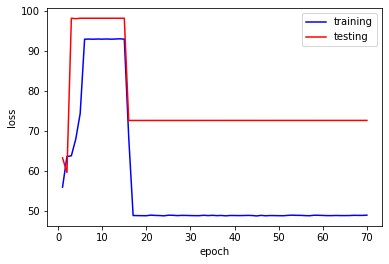

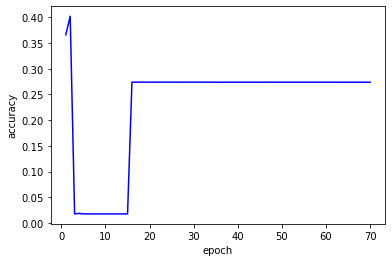

No handles with labels found to put in legend.


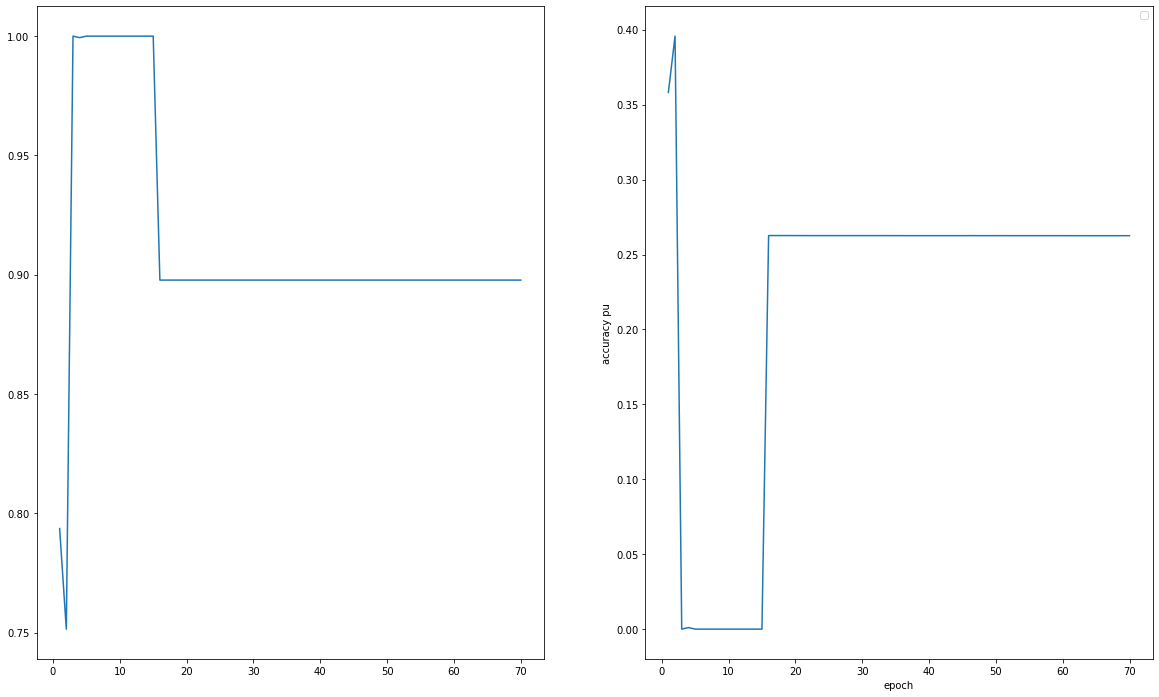

  3%|▎         | 5/168 [00:00<00:03, 48.94it/s]

epoch: 71


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.998525256202335


  2%|▏         | 3/168 [00:00<00:05, 28.08it/s]

test total acc, ele acc, pu acc: 0.27370388957210845 0.8977665932683234 0.2625679195293906
epoch: 72


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 49.04045992805844


  2%|▏         | 3/168 [00:00<00:05, 28.77it/s]

test total acc, ele acc, pu acc: 0.27369837479526393 0.8977665932683234 0.2625623063451435
epoch: 73


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.93848787035261


  4%|▎         | 6/168 [00:00<00:02, 56.46it/s]

test total acc, ele acc, pu acc: 0.27369837479526393 0.8977665932683234 0.2625623063451435
epoch: 74


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.915236949920654


  2%|▏         | 4/168 [00:00<00:04, 33.46it/s]

test total acc, ele acc, pu acc: 0.2736873452415748 0.8977665932683234 0.26255107997664917
epoch: 75


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.93622993287586


  4%|▎         | 6/168 [00:00<00:03, 53.44it/s]

test total acc, ele acc, pu acc: 0.2736873452415748 0.8977665932683234 0.26255107997664917
epoch: 76


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 49.03655324663435


  3%|▎         | 5/168 [00:00<00:03, 49.08it/s]

test total acc, ele acc, pu acc: 0.27368183046473027 0.8977665932683234 0.262545466792402
epoch: 77


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.91966129484631


  3%|▎         | 5/168 [00:00<00:03, 48.47it/s]

test total acc, ele acc, pu acc: 0.2736763156878857 0.8977665932683234 0.26253985360815485
epoch: 78


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.84353651319231


  2%|▏         | 3/168 [00:00<00:06, 26.73it/s]

test total acc, ele acc, pu acc: 0.2736708009110411 0.8977665932683234 0.26253424042390766
epoch: 79


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 49.03577952157883


  3%|▎         | 5/168 [00:00<00:03, 48.98it/s]

test total acc, ele acc, pu acc: 0.2736652861341966 0.8977665932683234 0.26252862723966053
epoch: 80


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.92149230412075


100%|██████████| 42/42 [00:14<00:00,  2.92it/s]


test total acc, ele acc, pu acc: 0.2736652861341966 0.8977665932683234 0.26252862723966053


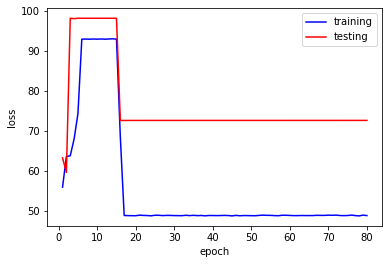

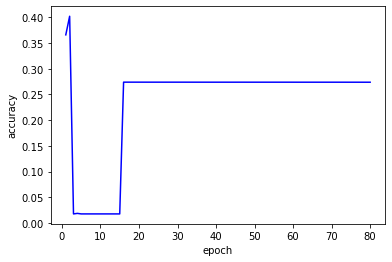

No handles with labels found to put in legend.


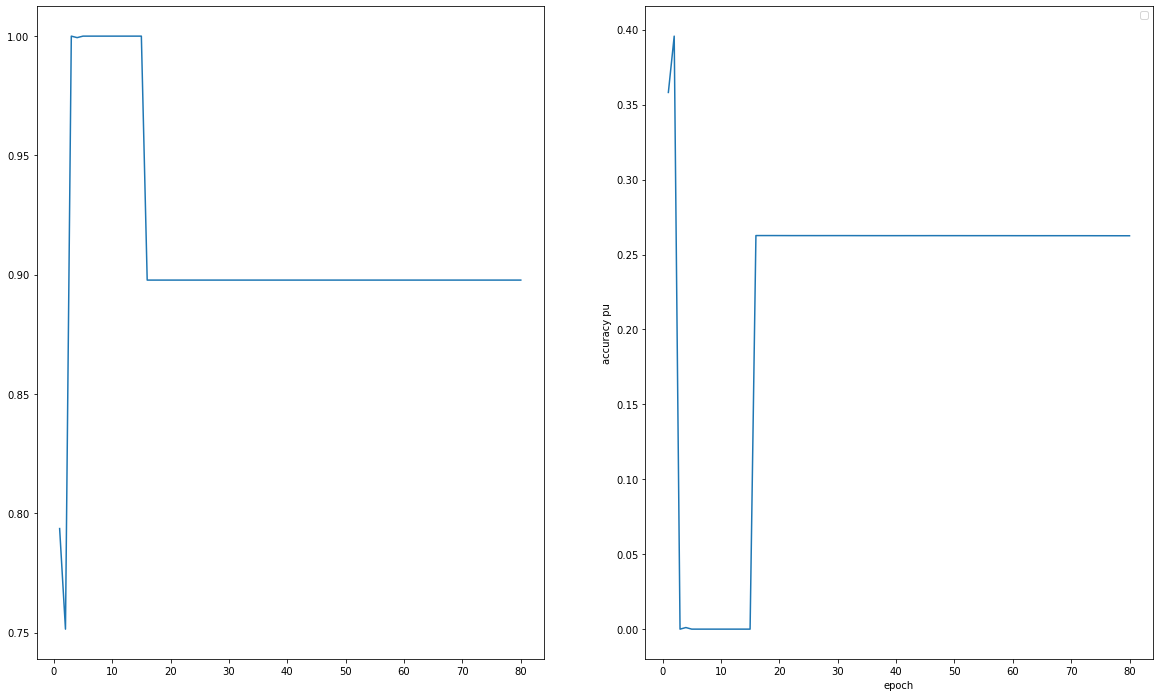

  4%|▎         | 6/168 [00:00<00:03, 53.94it/s]

epoch: 81


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.86668466386341


  2%|▏         | 3/168 [00:00<00:05, 28.56it/s]

test total acc, ele acc, pu acc: 0.2736652861341966 0.8977665932683234 0.26252862723966053
epoch: 82


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.99957833971296


  4%|▎         | 6/168 [00:00<00:02, 58.77it/s]

test total acc, ele acc, pu acc: 0.27365977135735203 0.8977665932683234 0.26252301405541334
epoch: 83


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.96687453133719


  3%|▎         | 5/168 [00:00<00:03, 48.53it/s]

test total acc, ele acc, pu acc: 0.27365977135735203 0.8977665932683234 0.26252301405541334
epoch: 84


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.86478165217808


  3%|▎         | 5/168 [00:00<00:03, 48.40it/s]

test total acc, ele acc, pu acc: 0.27365425658050746 0.8977665932683234 0.2625174008711662
epoch: 85


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 48.9956636428833


 40%|████      | 17/42 [00:05<00:08,  3.02it/s]

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)


from tqdm import tqdm as tqdm
checkpoint_dir = '/home/llr/cms/sghosh/hackathonTICL/model_edgenetwork/'

os.makedirs(checkpoint_dir, exist_ok=True)
best_loss = 99999999
losst = []
lossv = []
epochs = []
acc = []
elc= []
puc = []


for epoch in range(1, 201):
    print ('epoch:',epoch)
    losst.append(train(epoch))
    loss_epoch,accuracy, eleacc, puacc = evaluate(epoch)
    lossv.append(loss_epoch)
    acc.append(accuracy)
    elc.append(eleacc)
    puc.append(puacc)
    epochs.append(epoch)
    print("test total acc, ele acc, pu acc:",accuracy,eleacc,puacc)
    checkpoint = {
    'epoch': epoch + 1,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
    }
    
    
    
    checkpoint_file = 'model_epoch_%i.pth.tar' % ( epoch )
    torch.save(checkpoint,
                   os.path.join(checkpoint_dir,checkpoint_file ))
    if loss_epoch < best_loss:
        best_loss = loss_epoch
        print('new best test loss:',best_loss)
        torch.save(checkpoint,
                   os.path.join(checkpoint_dir,'model_checkpoint_best.pth.tar' ))
    if (epoch%10 == 0):
        plt.plot(np.array(epochs),np.array(losst),c='b',label='training')
        plt.plot(np.array(epochs),np.array(lossv),c='r',label='testing')
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend()
        plt.savefig(checkpoint_dir+'loss_{0}.png'.format(epoch))
        plt.show()
        plt.plot(np.array(epochs),np.array(acc),c='b')
        plt.xlabel("epoch")
        plt.ylabel("accuracy")
        plt.savefig(checkpoint_dir+'acc_class_{0}.png'.format(epoch))
        plt.show()
        fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(20,12))
        ax0.plot(np.array(epochs),np.array(elc))#,label=str(etabinsG[i])+"_to_"+str(etabinsG[i+1]))
        ax1.set_xlabel("epoch")
        ax1.set_ylabel("accuracy ele")
        ax1.plot(np.array(epochs),np.array(puc))#,label=str(etabinsG[i])+"_to_"+str(etabinsG[i+1]))
        ax1.set_xlabel("epoch")
        ax1.set_ylabel("accuracy pu")
        plt.legend()
        plt.savefig(checkpoint_dir+'acc_class_feta_{0}.png'.format(epoch))
        plt.show()   
            
        
        
